In [105]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Created on Tue Mar 14 14:47:58 2023

@author: mariapopovic
"""

from numpy import array, exp, append, linspace, log, average, around, arange
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from math import erf, pi, sqrt
import random
from scipy.stats import norm
from statistics import mean

<BarContainer object of 8 artists>

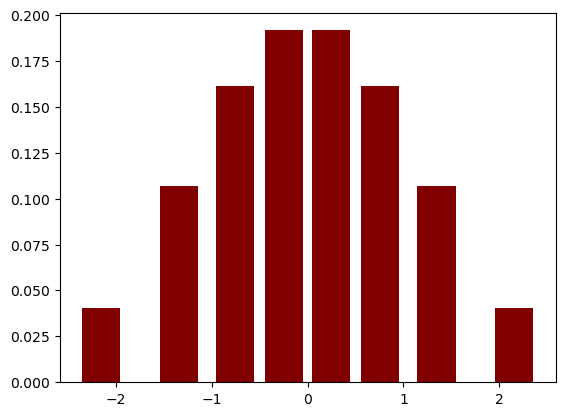

In [106]:
### Load data from files generated with Mathematica ###

n = [1,2,3,4,5,6,7,8,9,10,11]
probabilities_stationary = []
gammas = []
number_bins_list = []
number_bins_str = []

index = 0
for el in n:
    number_bins_list.append(2*(2**int(el)))
    number_bins_str.append(str(number_bins_list[index]))
    index = index + 1

for el in number_bins_str:
    prob = []
    gam = []
          
    f1=open("probabilities_NBins_" + el + ".txt", "r")

    if f1.mode == 'r':
        t=f1.readlines()

    for index in t:
        
        prob.append(float(index.replace('\n','')))
       
    f2=open("gammas_NBins_"+el+".txt", "r")

    if f2.mode == 'r':
        g=f2.readlines()

    for index in g:
        gam.append(float(index.replace('\n','')))
      
    
    gammas.append(gam)
    probabilities_stationary.append(prob)

# Plots one example, in this case for 2^3 bins

plt.bar(gammas[1], probabilities_stationary[1], color ='maroon', width=0.4)

In [107]:
### Create linear quantizers in equal length intervals with corresponding CDFs ###

# Initiate lists: each elemement will also be a list corresponding to 2^2 number of bins, 2^3, 2^4 etc

knots_linear = []
extreme_cell_bounds = []
cell_bounds_linear = []
cdf_linear_rightbound = []

for index in range(0,len(number_bins_list)):
    
    # Create knots for linear quantizers from the gamma functions
    
    kl = linspace(gammas[index][0], gammas[index][-1], number_bins_list[index])
    knots_linear.append(kl)        

    # Fix the two extreme points for the interval in which the cells are located: the extreme Voronoi cells are
    # unbounded, so we bound them by taking the value after the marginal knots for which the standard normal has less
    # than 1% probability
    
    j = 0.1
    guess = round(gammas[index][0]) - j
    normal_distribution = norm(0,1).pdf(guess)
    
    while normal_distribution >= 0.01:
        j = j + 0.1
        guess = round(gammas[index][0]) - j
        normal_distribution = norm(0,1).pdf(guess)
        
    extreme_cell_bounds.append([norm.ppf(normal_distribution), norm.ppf(1 - normal_distribution)])

    # Append extreme left bound

    cell_bounds_linear.append([extreme_cell_bounds[index][0]])
    
    for index2 in range(1,len(knots_linear[index])):
    
        cell_bounds_linear[index].append((knots_linear[index][index2] + knots_linear[index][index2 - 1])/2)
        
    # Append extreme right bound
    
    cell_bounds_linear[index].append(extreme_cell_bounds[index][1])
    
    # Define the cumulative distribution function from the right extreme of each cell

    cdf_linear_rightbound.append(norm.cdf(cell_bounds_linear[index][1:]))
    
    # Round last element to = 1

    tmp = cdf_linear_rightbound[index][:-1]
    cdf_linear_rightbound[index] = append(tmp,round(cdf_linear_rightbound[index][-1]))
    
    knots_linear[index] = around(knots_linear[index],5)
    cdf_linear_rightbound[index] = around(cdf_linear_rightbound[index],5)


In [108]:
### Create stationary quantizers ###

knots_stationary = []
cell_bounds_stationary = []
cdf_stationary_rightbound = []

for index in range(0,len(number_bins_list)):

    # The stationary knots are just the gammas that solve the system of equations

    knots_stationary = gammas
    
    # Append extreme left bound, which is the same as the linear case
    
    cell_bounds_stationary.append([extreme_cell_bounds[index][0]])
    
    for index2 in range(1,len(knots_stationary[index])):
    
        cell_bounds_stationary[index].append((knots_stationary[index][index2] + knots_stationary[index][index2 - 1])/2)
        
    # Append extreme right bound
    
    cell_bounds_stationary[index].append(extreme_cell_bounds[index][1])
    
    # Define the cumulative distribution function from the right extreme of each cell

    cdf_stationary_rightbound.append(norm.cdf(cell_bounds_stationary[index][1:]))

    # Round last element to = 1
    
    tmp = cdf_stationary_rightbound[index][:-1]
    cdf_stationary_rightbound[index] = append(tmp,round(cdf_stationary_rightbound[index][-1]))
    
    knots_stationary[index] = around(knots_stationary[index],5)
    cdf_stationary_rightbound[index] = around(cdf_stationary_rightbound[index],5)



In [97]:
### Simulation of the stockprice process ###

int_rate = 0.05 # Interest rate
K = 1 # Strike
sigma = 0.2 # Volatility
s_0 = 1 # Spot
T = 0.25 # Expiry
        
def stockprice_process(y):

    s_T = s_0*exp((int_rate - 0.5*(sigma**2))*T + sigma*sqrt(T)*y)
        
    return s_T

# Data we have for current year (t = 0)

data_value_option_pricing = 0.04615
data_option_pricing = [data_value_option_pricing]*len(number_bins_list)

number_simulations = 5000 # Change to set number of samples per simulation



# Initialize counts

count_linear = [0]*len(number_bins_list)
count_stationary = [0]*len(number_bins_list)
total_counts = 20 # Change to set number of simulations
ct = 1

while ct <= total_counts:

    # Initialize stockprice simulations
    
    stockprice_linear = []
    stockprice_stationary = []
    blackscholes_linear = []
    blackscholes_stationary = []
    
    for index_bins in range(0,len(number_bins_list)):
    
    
        stockprice_linear_iterations = []
        stockprice_stationary_iterations = []
        blackscholes_linear_iterations = []
        blackscholes_stationary_iterations = []
    
        iterations = 0
    
        while iterations < number_simulations:
    
            u = random.uniform(0,1)

    # Finds the CDF to which domain the random number belongs to and assigns the corresponding quantizer/knot
    # This code corresponds to the operation y = F^(-1) (u) with u random variable in [0,1], 
    # and where F is CDF

            index2 = 0
    
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]

  
            index2 = 0
    
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            y_stationary = knots_stationary[index_bins][index2]
        
            stockprice_linear_iterations.append(stockprice_process(y_linear))
            stockprice_stationary_iterations.append(stockprice_process(y_stationary))
        
            blackscholes_linear_iterations.append(max(stockprice_process(y_linear)-K,0))
            blackscholes_stationary_iterations.append(max(stockprice_process(y_stationary)-K,0))
        
            iterations = iterations + 1
        # End of 'while' loop for iterations
        
        stockprice_linear.append(average(stockprice_linear_iterations))
        stockprice_stationary.append(average(stockprice_stationary_iterations))
    
        blackscholes_linear.append(average(blackscholes_linear_iterations))
        blackscholes_stationary.append(average(blackscholes_stationary_iterations))
    
        # Check if the average (S - K)^+ obtained is within 0.01% of the real value: this counts how many times
        # the average value comes within +/- 0.0001 of the real value
    
        if abs(blackscholes_linear[index_bins] - data_value_option_pricing) <= 0.0001:
            count_linear[index_bins] = count_linear[index_bins] + 1
        if abs(blackscholes_stationary[index_bins] - data_value_option_pricing) <= 0.0001:
            count_stationary[index_bins] = count_stationary[index_bins] + 1
    # End of 'for' loop for bins
    
    ct = ct + 1
# End of 'while' loop for counts

In [98]:
print("For linear quantizers, "+str(total_counts)+" runs, "+ "counts within 0.0001 of real value")
for index in range(0,len(count_linear)):
    print("Bins: "+ str(number_bins_list[index])+"  Counts: "+str(count_linear[index]))
    
print("For stationary quantizers, "+str(total_counts)+" runs, "+ "counts within 0.0001 of real value")
for index in range(0,len(count_stationary)):
    print("Bins: "+ str(number_bins_list[index])+"  Counts: "+str(count_stationary[index]))
    

For linear quantizers, 20 runs, counts within 0.0001 of real value
Bins: 4  Counts: 0
Bins: 8  Counts: 1
Bins: 16  Counts: 0
Bins: 32  Counts: 3
Bins: 64  Counts: 1
Bins: 128  Counts: 0
Bins: 256  Counts: 2
Bins: 512  Counts: 1
Bins: 1024  Counts: 2
Bins: 2048  Counts: 4
Bins: 4096  Counts: 1
For stationary quantizers, 20 runs, counts within 0.0001 of real value
Bins: 4  Counts: 3
Bins: 8  Counts: 4
Bins: 16  Counts: 0
Bins: 32  Counts: 1
Bins: 64  Counts: 1
Bins: 128  Counts: 0
Bins: 256  Counts: 2
Bins: 512  Counts: 1
Bins: 1024  Counts: 2
Bins: 2048  Counts: 4
Bins: 4096  Counts: 1


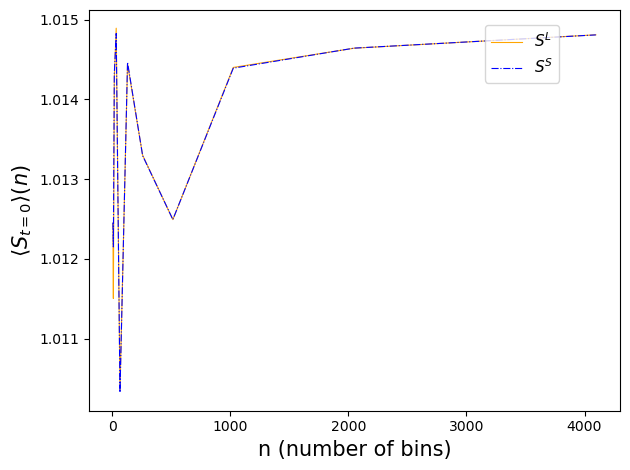

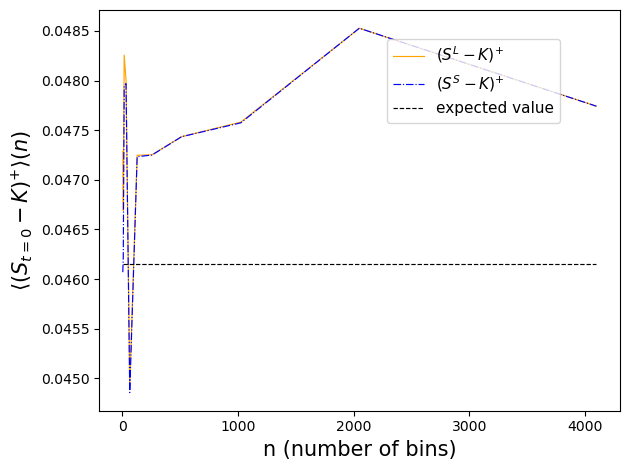

In [99]:
f1 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,stockprice_linear,label=r'$S^{L}$', linewidth = 0.8, color = 'orange')
ax.plot(number_bins_list,stockprice_stationary,label=r'$S^{S}$',linewidth=0.8, color = 'blue',linestyle='dashdot')

ax.set_xlabel('n (number of bins)',fontsize=15)
ax.set_ylabel(r'$\langle S_{t = 0} \rangle (n)$',fontsize=15)

plt.tight_layout()
plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.8),fontsize=11)


plt.show()

f2 = plt.figure(1)
ax2=plt.axes()

ax2.plot(number_bins_list,blackscholes_linear,label=r'$(S^{L} - K)^{+}$', linewidth = 0.85, color = 'orange')
ax2.plot(number_bins_list,blackscholes_stationary,label=r'$(S^{S} - K)^{+}$',linewidth=0.85, color = 'blue',linestyle='dashdot')
ax2.plot(number_bins_list,data_option_pricing,label='expected value',linewidth=0.85, color = 'black',linestyle='dashed')

ax2.set_xlabel('n (number of bins)',fontsize=15)
ax2.set_ylabel(r'$\langle (S_{t = 0} - K)^{+}\rangle (n)$',fontsize=15)

plt.tight_layout()
plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.7),fontsize=11)


plt.show()


In [116]:
### Time dependent stockprice function ###

int_rate = 0.05 # Interest rate
K = 1 # Strike
sigma = 0.2 # Volatility
s_0 = 1 # Spot
T = 0.25 # Expiry

def geometric_brownian_motion (y,t):
    s_t = s_0*exp((int_rate - 0.5*(sigma**2))*(T-t) + sigma*(sqrt(T)-sqrt(t))*y)
    return s_t

# Prepare time axes

time = []
time_step = 0.01

for t in arange(0,T + time_step,time_step):
    time.append(t)
    
number_simulations = 3000    

stockprice_linear_bins = []
stockprice_stationary_bins = []

for index_bins in range(0,len(number_bins_list)):

    # Initialize stockprice simulations
    
    stockprice_linear = []
    stockprice_stationary = []

    for t in time:
    
    
        stockprice_linear_iterations = []
        stockprice_stationary_iterations = []

        iterations = 0
    
        while iterations < number_simulations:
    
            u = random.uniform(0,1)

    # Finds the CDF to which domain the random number belongs to and assigns the corresponding quantizer/knot
    # This code corresponds to the operation y = F^(-1) (u) with u random variable in [0,1], 
    # and where F is CDF

            index2 = 0
    
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]

  
            index2 = 0
    
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            y_stationary = knots_stationary[index_bins][index2]
        
            stockprice_linear_iterations.append(geometric_brownian_motion(y_linear,t))
            stockprice_stationary_iterations.append(geometric_brownian_motion(y_stationary,t))
        
        
            iterations = iterations + 1
        # End of 'while' loop for iterations
        
        stockprice_linear.append(average(stockprice_linear_iterations))
        stockprice_stationary.append(average(stockprice_stationary_iterations))
        
    stockprice_linear_bins.append(stockprice_linear)
    stockprice_stationary_bins.append(stockprice_stationary)
    

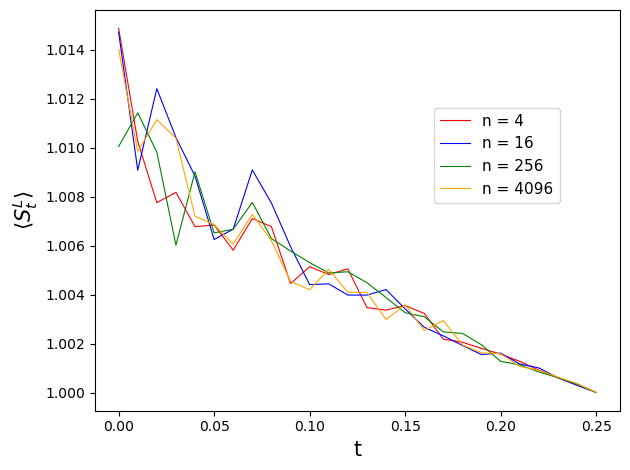

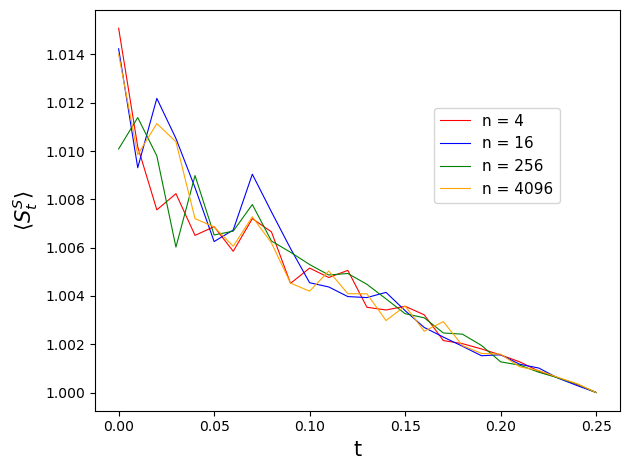

In [127]:
f3 = plt.figure(1)
ax3=plt.axes()

ax3.plot(time,stockprice_linear_bins[0],label='n = '+ str(number_bins_list[0]), linewidth = 0.8, color = 'red')
ax3.plot(time,stockprice_linear_bins[2],label='n = '+ str(number_bins_list[2]),linewidth=0.8, color = 'blue',)
ax3.plot(time,stockprice_linear_bins[6],label='n = '+ str(number_bins_list[6]),linewidth=0.8, color = 'green')
ax3.plot(time,stockprice_linear_bins[10],label='n = '+ str(number_bins_list[10]),linewidth=0.8, color = 'orange')

ax3.set_xlabel('t',fontsize=15)
ax3.set_ylabel(r'$\langle S^{L}_{t} \rangle$',fontsize=15)

plt.tight_layout()
plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.5),fontsize=11)


plt.show()

f4 = plt.figure(1)
ax4=plt.axes()

ax4.plot(time,stockprice_stationary_bins[0],label='n = '+ str(number_bins_list[0]), linewidth = 0.8, color = 'red')
ax4.plot(time,stockprice_stationary_bins[2],label='n = '+ str(number_bins_list[2]),linewidth=0.8, color = 'blue',)
ax4.plot(time,stockprice_stationary_bins[6],label='n = '+ str(number_bins_list[6]),linewidth=0.8, color = 'green')
ax4.plot(time,stockprice_stationary_bins[10],label='n = '+ str(number_bins_list[10]),linewidth=0.8, color = 'orange')

ax4.set_xlabel('t',fontsize=15)
ax4.set_ylabel(r'$\langle S^{S}_{t} \rangle$',fontsize=15)

plt.tight_layout()
plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.5),fontsize=11)


plt.show()

In [ ]:
### Optimal quantizers on 2 factor models: g2++ model ###


def two_factor_additive_gaussian_model (dt,x1,x2,k1,k2,sigma1,sigma2,phi,y1,y2):
    dx1 = -k1*x1*dt + sigma1*y1
    dx2 = -k2*x2*dt + sigma2*y2
    
    x1 = x1 + dx1
    x2 = x2 + dx2
    
    r = x1 + x2 + phi
    
    return r
    
    
    